In [1]:
    # !pip install medmnist

In [2]:
# https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F

from tqdm import tqdm

%aimport vq_vae_model

%aimport utils
from utils import plot_real_vs_constructed 
# from basic_vae import VariationalAutoencoder

C:\Users\kella\anaconda3\envs\dgm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_flag = 'pathmnist'
#data_flag = 'breastmnist'
# data_flag = 'octmnist'
# data_flag = 'chestmnist'
#data_flag = 'bloodmnist'
#data_flag = 'organamnist'
#data_flag = 'tissuemnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 64
lr = 0.0001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      #transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


Using downloaded and verified file: C:\Users\kella\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\kella\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\kella\.medmnist\pathmnist.npz


In [4]:
train_dataset.imgs.shape

(89996, 28, 28, 3)

C:\Users\kella\anaconda3\envs\dgm\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


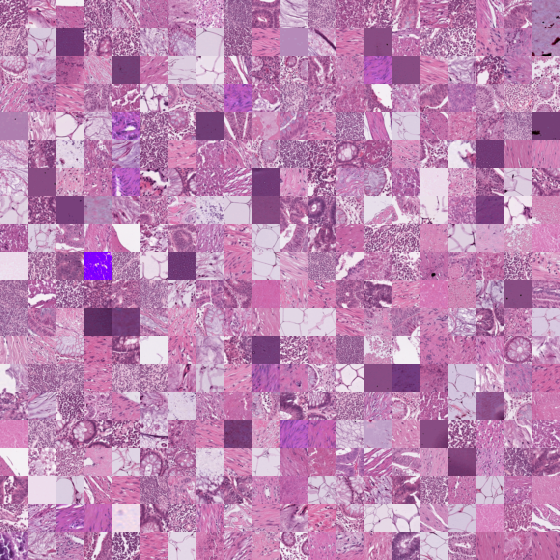

In [5]:
train_dataset.montage()

In [6]:
train_dataset.imgs.max()

255

In [7]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3
channel = 3


epochs=100
path = "{}_epochs_{}.tar".format(data_flag,epochs)

In [8]:
from vq_vae_model import VariationalAutoencoder


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost,decay,input_channel=channel ,output_channel=channel ).to(device) # GPU


#vae.train(train_loader, lr=0.0001, epochs=10, device=device)
# plot_latent(vae, train_loader)

100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:33<00:00, 42.12it/s]


1 iterations
recon_error: 0.133
perplexity: 5.747



100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:31<00:00, 44.53it/s]


2 iterations
recon_error: 0.090
perplexity: 10.244



100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:32<00:00, 43.66it/s]


3 iterations
recon_error: 0.080
perplexity: 14.848



100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:31<00:00, 44.47it/s]


4 iterations
recon_error: 0.074
perplexity: 19.158



100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:31<00:00, 43.99it/s]


5 iterations
recon_error: 0.072
perplexity: 23.518



100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:31<00:00, 44.49it/s]


6 iterations
recon_error: 0.062
perplexity: 35.540



100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:31<00:00, 44.27it/s]


7 iterations
recon_error: 0.058
perplexity: 47.854



100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:31<00:00, 44.42it/s]


8 iterations
recon_error: 0.056
perplexity: 62.946



100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:31<00:00, 44.33it/s]


9 iterations
recon_error: 0.054
perplexity: 79.480



100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:31<00:00, 44.23it/s]

10 iterations
recon_error: 0.051
perplexity: 105.849



In [9]:
vae.save_to_file(path)
#vae.load_from_file(path)

NameError: name 'epochs' is not defined

In [14]:
def plot_real_vs_constructed(vae, test_dataset, device):
    imgs = np.zeros((4*29, 8*29, 3))
    diff = 0.
    for i in range(8):
        test_img = test_dataset[i][0][None,:,:,:].to(device)
        print("shape of test_img",test_img.shape)
        z = vae._encoder(test_img)
        print("shape after _encoder",z.shape)
        z = vae._pre_vq_conv(z)
        print("shape after _pre_vq_conv",z.shape)
        loss, quantized, perplexity, _ = vae._vq_vae(z)
        print("shape after _vq_vae",quantized.shape)
        img = vae._decoder(quantized)


        imgs[:28, i*28+(i*1):(i+1)*28+(i*1), :] = test_img[0].moveaxis(0, 2).cpu().detach().numpy()
        imgs[28+1:28*2+1, i*28+(i*1):(i+1)*28+(i*1), :] = img[0].moveaxis(0, 2).cpu().detach().numpy()

        diff += ((test_img - img)**2).mean()

    for i in range(8):
        test_img = test_dataset[i+8][0][None,:,:,:].to(device)
        z = vae._encoder(test_img)
        z = vae._pre_vq_conv(z)
        loss, quantized, perplexity, _ = vae._vq_vae(z)
        img = vae._decoder(quantized)

        imgs[2*29+1:3*28+3, i*28+(i*1):(i+1)*28+(i*1), :] = test_img[0].moveaxis(0, 2).cpu().detach().numpy()
        imgs[3*28+4:, i*28+(i*1):(i+1)*28+(i*1), :] = img[0].moveaxis(0, 2).cpu().detach().numpy()

        diff += ((test_img - img)**2).mean()

    print((diff/8).item())        
    plt.figure(figsize=(20,20))
    plt.imshow(imgs, cmap="gray")
    plt.plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of test_img torch.Size([1, 3, 28, 28])
shape after _encoder torch.Size([1, 128, 7, 7])
shape after _pre_vq_conv torch.Size([1, 64, 7, 7])
shape after _vq_vae torch.Size([1, 64, 7, 7])
shape of test_img torch.Size([1, 3, 28, 28])
shape after _encoder torch.Size([1, 128, 7, 7])
shape after _pre_vq_conv torch.Size([1, 64, 7, 7])
shape after _vq_vae torch.Size([1, 64, 7, 7])
shape of test_img torch.Size([1, 3, 28, 28])
shape after _encoder torch.Size([1, 128, 7, 7])
shape after _pre_vq_conv torch.Size([1, 64, 7, 7])
shape after _vq_vae torch.Size([1, 64, 7, 7])
shape of test_img torch.Size([1, 3, 28, 28])
shape after _encoder torch.Size([1, 128, 7, 7])
shape after _pre_vq_conv torch.Size([1, 64, 7, 7])
shape after _vq_vae torch.Size([1, 64, 7, 7])
shape of test_img torch.Size([1, 3, 28, 28])
shape after _encoder torch.Size([1, 128, 7, 7])
shape after _pre_vq_conv torch.Size([1, 64, 7, 7])
shape after _vq_vae torch.Size([1, 64, 7, 7])
shape of test_img torch.Size([1, 3, 28, 28])
shape

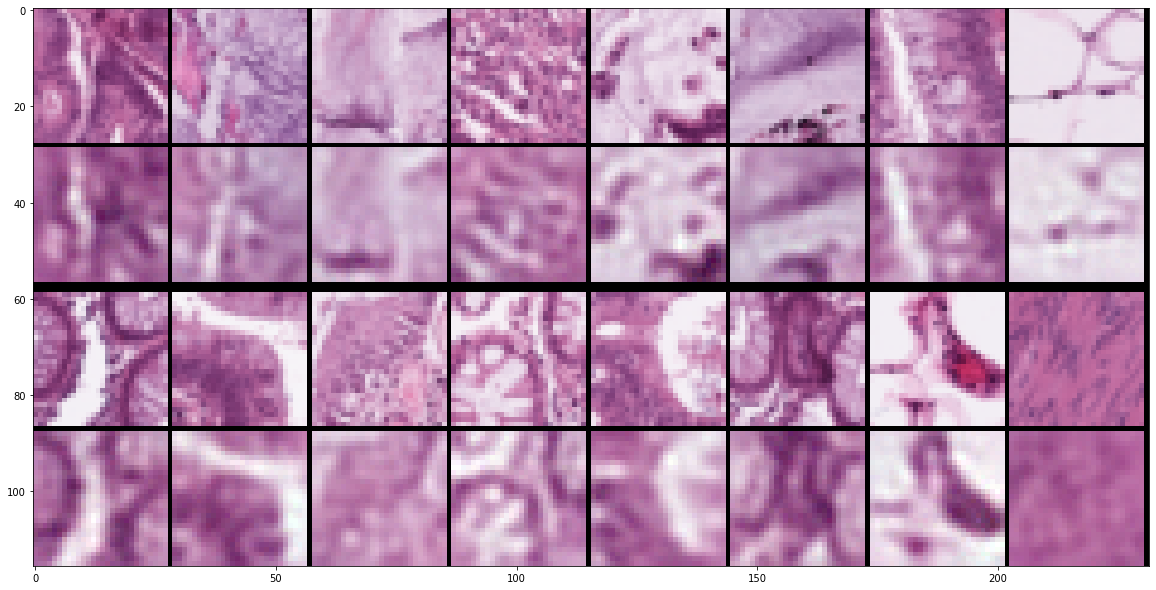

In [15]:
plot_real_vs_constructed(vae, test_dataset, device)

In [55]:
torch.save({
  'epoch': epochs,
  'encoder': vae._encoder.state_dict(),
  'pre_vq_conv': vae._pre_vq_conv.state_dict(),
  "decoder": vae._decoder.state_dict()
}, path)

In [56]:
vae_load = VariationalAutoencoder(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost,decay,input_channel=channel ,output_channel=channel ).to(device)
checkpoint = torch.load(path)
vae_load._encoder.load_state_dict(checkpoint['encoder'])
vae_load._pre_vq_conv.load_state_dict(checkpoint['pre_vq_conv'])
vae_load._decoder.load_state_dict(checkpoint[ "decoder"])

<All keys matched successfully>

torch.Size([1, 12, 12])


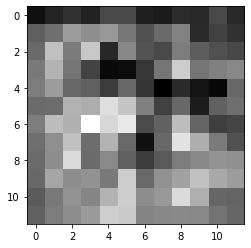

In [20]:
z = torch.randint(-1,1, (embedding_dim,3,3), dtype=torch.float, device=device)
img = vae._decoder.forward(z)
print(img.shape)
# img = F.normalize(img)
plt.imshow(img.cpu().detach().numpy()[0], cmap="gray")
# plt.imshow(img.moveaxis(1, 3).cpu().detach().numpy()[0])
plt.show()

In [21]:
test_img = test_dataset[5][0][None,:,:,:].to(device)
lat = vae.encoder.forward(test_img)
img = vae.decoder.forward(lat)

AttributeError: 'VariationalAutoencoder' object has no attribute 'encoder'

[]

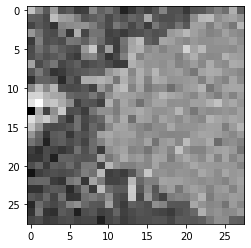

In [22]:
plt.imshow(test_img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
plt.plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]

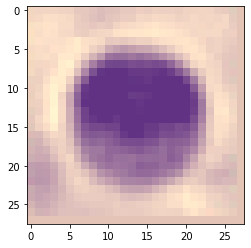

In [105]:
# img = F.normalize(img)
plt.imshow(img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
plt.plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


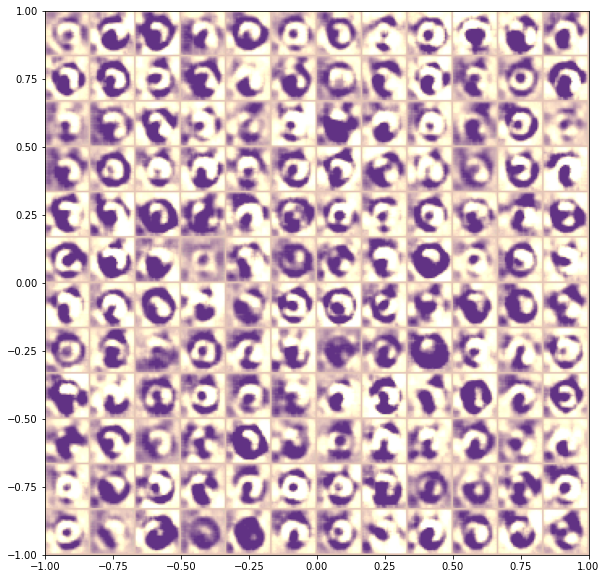

In [106]:
plot_reconstructed(vae, r0=(-1, 1), r1=(-1, 1), latent_dim=latent_dims)

# New Section

In [21]:
i = torch.randn((3, 28, 28))
cov1 = nn.Conv2d(3, 6, 3, stride=2)
cov2 = nn.Conv2d(6, 12, 3, stride=2)
m1 = nn.MaxPool2d(2)
m2 = nn.MaxUnpool2d(3)
lin1 = nn.Linear(75,108)
cov3 = nn.ConvTranspose2d(12,6,3, stride=2)#, output_padding=1)
cov4 = nn.ConvTranspose2d(6,3,3, stride=2, output_padding=1)
cov5 = nn.ConvTranspose2d(3,3,1, stride=1)#, output_padding=1)
print(i.flatten().shape, i.shape)
x = cov1(i)
x = cov2(x)
# x = m1(x)
print(x.flatten().shape, x.shape)
# x = lin1(x.flatten())
# x = x.reshape(3,6,6)
x = cov3(x)
x = cov4(x)
# x = cov4_5(x)
x = cov5(x)
# x = m2(x)
print(x.flatten().shape, x.shape)


torch.Size([2352]) torch.Size([3, 28, 28])
torch.Size([432]) torch.Size([12, 6, 6])
torch.Size([2352]) torch.Size([3, 28, 28])
